##  Importing Dependencies
   

In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.utils import plot_model
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.8.0


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


#  Dataset Preprocessing


In [46]:
df = pd.read_csv('Acc 84/TwitterDataset.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2
0,target,tweet,username
1,1,the real reason why you're sad? you're attache...,depressingmsgs
2,1,my biggest problem is overthinking everything,depressingmsgs
3,1,the worst sadness is the sadness you've taught...,depressingmsgs
4,1,i cannot make you understand. i cannot make an...,depressingmsgs


You can see the columns are without any proper names. Lets rename them for our reference

In [47]:
df.columns = ['sentiment', 'text', 'user_id']
df.head()

,sentiment,text,user_id
0,target,tweet,username
1,1,the real reason why you're sad? you're attache...,depressingmsgs
2,1,my biggest problem is overthinking everything,depressingmsgs
3,1,the worst sadness is the sadness you've taught...,depressingmsgs
4,1,i cannot make you understand. i cannot make an...,depressingmsgs


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [48]:
df = df.drop(['user_id'], axis=1)

In [49]:
df = df.iloc[1: , :]

In [50]:
df.head()

,sentiment,text
1,1,the real reason why you're sad? you're attache...
2,1,my biggest problem is overthinking everything
3,1,the worst sadness is the sadness you've taught...
4,1,i cannot make you understand. i cannot make an...
5,1,i don't think anyone really understands how ti...


Text(0.5, 1.0, 'Sentiment Data Distribution')

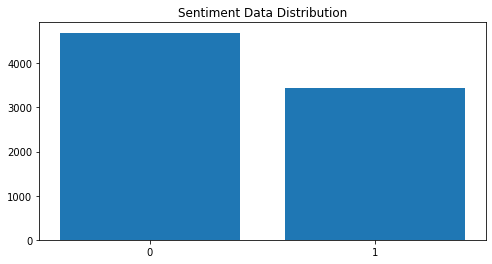

In [51]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [52]:
df.sentiment.value_counts()

0    4695
1    3440
Name: sentiment, dtype: int64

In [13]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [14]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [15]:
df.text = df.text.apply(lambda x: preprocess(x))

## Train and Test Split

In [16]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [17]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 6508
Test Data size 1627


In [18]:
train_data.head(10)

,sentiment,text
5148,0,sometimes give much soon sometimes hold back l...
6805,0,true way create loving productive fulfilling l...
7299,0,cvs carry vaccine protects long receipts right...
5693,0,directions instructions given explain directio...
3324,1,better get
5935,0,guess whose lead swift lot still time
5341,0,seen check davidkwong tedtalks still trying fi...
7290,0,honored included americanmasterspbs documentar...
4159,0,new handle new meeeee
6773,0,keep purpose mind trust guidance receive faith...


In [19]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 9301


In [20]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (6508, 30)
Testing X Shape: (1627, 30)


In [21]:
labels = train_data.sentiment.unique().tolist()

### Label Encoding 


In [22]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (6508, 1)
y_test shape: (1627, 1)


!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [23]:
GLOVE_EMB = 'glove/glove.6B.300d.txt' 
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 30
MODEL_PATH = 'glove/output/best_model.hdf5'

In [24]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding="utf8")
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [25]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [26]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [27]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [30]:
# Cuda to used Rtx 2060
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [31]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           2790300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

In [33]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=10,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
7/7 [==============================] - 10s 298ms/step - loss: 0.6252 - accuracy: 0.5728 - val_loss: 0.5216 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - 2s 240ms/step - loss: 0.4574 - accuracy: 0.8113 - val_loss: 0.4417 - val_accuracy: 0.7996 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - 2s 237ms/step - loss: 0.3965 - accuracy: 0.8331 - val_loss: 0.4009 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - 2s 262ms/step - loss: 0.3531 - accuracy: 0.8480 - val_loss: 0.4569 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 5/10
7/7 [==============================] - 2s 230ms/step - loss: 0.3287 - accuracy: 0.8605 - val_loss: 0.4002 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 6/10
7/7 [==============================] - 2s 265ms/step - loss: 0.2999 - accuracy: 0.8712 - val_loss: 0.3868 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 7/10
7/7 [==============================] - 2s 262ms/step - loss: 0.2802 - 

# Model Evaluation


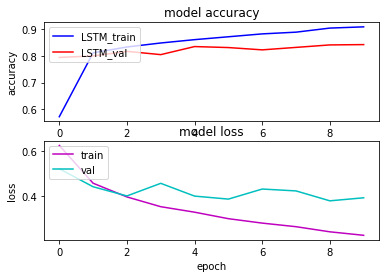

In [34]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [35]:
%%time
score = model.evaluate(x_test, y_test) #
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

51/51 [==============================] - 1s 27ms/step - loss: 0.3927 - accuracy: 0.8420

ACCURACY: 0.8420405387878418
LOSS: 0.39269739389419556
CPU times: total: 1.33 s
Wall time: 1.44 s


In [36]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 0s 389ms/step


### Classification Scores

In [37]:
score_train = model.evaluate(x_train, y_train , batch_size=1024)

7/7 [==============================] - 0s 28ms/step - loss: 0.1817 - accuracy: 0.9293


In [44]:
Train_scores = model.predict(x_train, verbose=1, batch_size=10000)
y_pred_1d_Train = [decode_sentiment(score) for score in Train_scores]
print(classification_report(y_train, y_pred_1d_Train))


1/1 [==============================] - 0s 301ms/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3774
           1       0.90      0.94      0.92      2734

    accuracy                           0.93      6508
   macro avg       0.93      0.93      0.93      6508
weighted avg       0.93      0.93      0.93      6508



In [39]:
from sklearn.metrics import classification_report
print("Training LSTM Model With Glove embedding word")
print("Training accuracy:",score_train[1])
print("Testing accuracy:",score[1])
print("LOSS:",score[0])
print(classification_report(y_test, y_pred_1d))

Training LSTM Model With Glove embedding word
Training accuracy: 0.9293177723884583
Testing accuracy: 0.8420405387878418
LOSS: 0.39269739389419556
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       921
           1       0.77      0.90      0.83       706

    accuracy                           0.84      1627
   macro avg       0.84      0.85      0.84      1627
weighted avg       0.85      0.84      0.84      1627



In [45]:
model.save('Glove_Lstm_Model.h5')
model.save('Glove_model.bin')


INFO:tensorflow:Assets written to: Glove_model.bin\assets


In [47]:
import pickle
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"), protocol=0)
pickle.dump(encoder, open("encoder.pkl", "wb"), protocol=0)

In [48]:
model.save('Glove_Lstm_Model.hdf5')

In [1]:
20/2.0

10.0

In [5]:
import pandas as pd
d = {'a': 1, 'b': 2, 'c': 3}
ser = pd.Series(data=d, index=['a', 'b', 'c'])
ser.idxmax()

'c'